<a href="https://colab.research.google.com/github/knoppin1/DATA-690-WANG/blob/master/Assignment_09/Assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Import Necessary Files

In [ ]:
import os
from random import *
import pandas as pd
import matplotlib.pyplot as plt
import plotly

# Libraries below are used in retrieving the zip file
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# 2 - Read Election Data 

2020 Presidential Candidate County Level Data 

- File is available from Kaggle  
- https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv

This attempt below to automatically download the file didn't work...
````
!pip install wget
import wget
url = 'https://www.kaggle.com/unanimad/us-election-2020/president_county_candidate.csv'
filename = wget.download(url)
````

So, manually download "*president_county_candidate.csv*" file from Kaggle and load it into Jupyter session.

In [ ]:
filename = 'president_county_candidate.csv'

Read the CSV file

In [ ]:
df = pd.read_csv(filename, header=0, sep=',', error_bad_lines=False) 
df.shape

(31407, 6)

In [ ]:
df.head()

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True


In [ ]:
df.tail()

,state,county,candidate,party,total_votes,won
31402,Arizona,Maricopa County,Donald Trump,REP,995665,False
31403,Arizona,Maricopa County,Jo Jorgensen,LIB,31705,False
31404,Arizona,Mohave County,Donald Trump,REP,78535,True
31405,Arizona,Mohave County,Joe Biden,DEM,24831,False
31406,Arizona,Mohave County,Jo Jorgensen,LIB,1302,False


# 3 - Clean Election Data


## 3.1 - Display summary information



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31407 entries, 0 to 31406
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        31407 non-null  object
 1   county       31407 non-null  object
 2   candidate    31407 non-null  object
 3   party        31407 non-null  object
 4   total_votes  31407 non-null  int64 
 5   won          31407 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.2+ MB


All columns have correct data types.

In [ ]:
df.describe(include =  'all')

,state,county,candidate,party,total_votes,won
count,31407,31407,31407,31407,3.140700e+04,31407
unique,51,3007,38,26,NaN,2
top,Vermont,Washington County,Donald Trump,DEM,NaN,False
freq,5412,180,4633,4633,NaN,26774
mean,NaN,NaN,NaN,NaN,5.016970e+03,NaN
std,NaN,NaN,NaN,NaN,3.574530e+04,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,3.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,3.500000e+01,NaN
75%,NaN,NaN,NaN,NaN,8.090000e+02,NaN


Notes:
- There are 31,407 records each representing voting results by candidate for each state/county.  
- There were 38 total candidates, but not all candidates were on each ballot. Only Donald Trump and Joe Biden are relevant to this study.
- There are 51 states (DC is counted as a state in the data set because it has electoral votes)
- 3007 counties are represented (DC has wards included as counties in the data)
- All counties have declared a winner

## 3.2 - Check for Missing Data

In [ ]:
df.isnull().sum()

state          0
county         0
candidate      0
party          0
total_votes    0
won            0
dtype: int64

There are no missing records.

## 3.3 - Remove Duplicate Rows

Find duplicates


In [ ]:
dups = df.duplicated(keep=False)
dups

0        False
1        False
2        False
3        False
4        False
         ...  
31402    False
31403    False
31404    False
31405    False
31406    False
Length: 31407, dtype: bool

Get index of any duplicates

Ref: https://stackoverflow.com/questions/52173161/getting-a-list-of-indices-where-pandas-boolean-series-is-true

In [ ]:
[i for i in dups.index if dups[i]]

[]

No duplicates exist.  

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(31407, 6)

Check specifically for candidate duplicate entries in any state/county 

In [ ]:
dups = df.duplicated(['state','county','candidate'],keep=False)
dups

0        False
1        False
2        False
3        False
4        False
         ...  
31402    False
31403    False
31404    False
31405    False
31406    False
Length: 31407, dtype: bool

In [ ]:
[i for i in dups.index if dups[i]]

[]

No duplicate entries for a candidate in any state/county

## 3.4 - Remove State/County Records Without Votes

In [ ]:
state_county_totals = df.groupby(by=['state','county']).sum('total_votes').sort_values('total_votes')
state_county_totals.reset_index(level=['state','county'], inplace=True)
state_county_totals

,state,county,total_votes,won
0,Maine,Sandy River Plt.,0,1
1,Maine,Blaine,0,1
2,Illinois,Hardin County,0,1
3,Maine,Oxford Cty Townships,0,1
4,Massachusetts,Clarksburg,0,1
...,...,...,...,...
4628,California,San Diego County,1600272,1
4629,Texas,Harris County,1640818,1
4630,Arizona,Maricopa County,2068144,1
4631,Illinois,Cook County,2306675,1


Get state/counties that didn't submit votes

In [ ]:
no_votes = state_county_totals.query('total_votes == 0')
no_votes

,state,county,total_votes,won
0,Maine,Sandy River Plt.,0,1
1,Maine,Blaine,0,1
2,Illinois,Hardin County,0,1
3,Maine,Oxford Cty Townships,0,1
4,Massachusetts,Clarksburg,0,1
...,...,...,...,...
127,Maine,Wellington,0,1
128,Maine,Washington Cty Townships,0,1
129,Maine,Carthage,0,1
130,Maine,Cary Plt.,0,1


Delete all rows from the master dataframe where the state and county are in the list without votes.

Ref: https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/

In [ ]:
bad_states = list(no_votes.state.unique())
bad_states

['Maine', 'Illinois', 'Massachusetts']

In [ ]:
bad_counties = list(no_votes.county.unique())
len(bad_counties)

132

In [ ]:
indexNames = df[df['state'].isin(bad_states) & df['county'].isin(bad_counties)].index 
len(indexNames)

860

Drop the records in indexNames list

In [ ]:
df.drop(indexNames , inplace=True)
df.shape

(30547, 6)

Dropped 860 records representing state/counties that did not submit candidate vote totals.

## 3.5 - Retain Only Biden & Trump Observations

In [ ]:
candidates_to_keep = ['Joe Biden','Donald Trump']
df = df[df.candidate.isin(candidates_to_keep)]
df.shape

(8972, 6)

In [ ]:
df.describe(include = 'all')

,state,county,candidate,party,total_votes,won
count,8972,8972,8972,8972,8.972000e+03,8972
unique,51,2895,2,2,NaN,2
top,Maine,Washington County,Donald Trump,REP,NaN,True
freq,750,54,4486,4486,NaN,4486
mean,NaN,NaN,NaN,NaN,1.721894e+04,NaN
std,NaN,NaN,NaN,NaN,6.529119e+04,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,1.042750e+03,NaN
50%,NaN,NaN,NaN,NaN,3.541000e+03,NaN
75%,NaN,NaN,NaN,NaN,1.030625e+04,NaN


# 4 - Review Wins at County Level

In [ ]:
state_county_grp = df.groupby(by=['state','county'])
state_county_grp.groups

{('Alabama', 'Autauga County'): [27334, 27335], ('Alabama', 'Baldwin County'): [27378, 27379], ('Alabama', 'Barbour County'): [27422, 27423], ('Alabama', 'Bibb County'): [27466, 27467], ('Alabama', 'Blount County'): [27510, 27511], ('Alabama', 'Bullock County'): [27546, 27547], ('Alabama', 'Butler County'): [27550, 27551], ('Alabama', 'Calhoun County'): [27554, 27555], ('Alabama', 'Chambers County'): [27558, 27559], ('Alabama', 'Cherokee County'): [27294, 27295], ('Alabama', 'Chilton County'): [27298, 27299], ('Alabama', 'Choctaw County'): [27302, 27303], ('Alabama', 'Clarke County'): [27306, 27307], ('Alabama', 'Clay County'): [27310, 27311], ('Alabama', 'Cleburne County'): [27314, 27315], ('Alabama', 'Coffee County'): [27318, 27319], ('Alabama', 'Colbert County'): [27322, 27323], ('Alabama', 'Conecuh County'): [27326, 27327], ('Alabama', 'Coosa County'): [27330, 27331], ('Alabama', 'Covington County'): [27338, 27339], ('Alabama', 'Crenshaw County'): [27342, 27343], ('Alabama', 'Cullm

Display winner for each county in each state.

In [ ]:
county_winners = state_county_grp.first().sort_values('won',ascending=False)
county_winners.reset_index(level=['state','county'], inplace=True)
county_winners

,state,county,candidate,party,total_votes,won
0,Alabama,Autauga County,Donald Trump,REP,19764,True
1,North Carolina,Chowan County,Donald Trump,REP,4471,True
2,North Carolina,Currituck County,Donald Trump,REP,11657,True
3,North Carolina,Cumberland County,Joe Biden,DEM,84469,True
4,North Carolina,Craven County,Donald Trump,REP,31032,True
...,...,...,...,...,...,...
4481,Maine,Hartford,Donald Trump,REP,428,True
4482,Maine,Hartland,Donald Trump,REP,610,True
4483,Maine,Hebron,Donald Trump,REP,427,True
4484,Maine,Hermon,Donald Trump,REP,2427,True


Display number of county wins for each candidate.

In [ ]:
wins = county_winners.groupby(by='candidate').count()
wins['won']

candidate
Donald Trump    3122
Joe Biden       1364
Name: won, dtype: int64

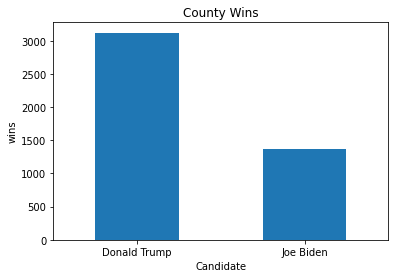

In [ ]:
ax = wins['won'].plot.bar(x='candidate', rot=0, xlabel='Candidate', ylabel='wins', title='County Wins')

In [ ]:
df.sort_values('total_votes', ascending=False)

,state,county,candidate,party,total_votes,won
28871,California,Los Angeles County,Joe Biden,DEM,3020546,True
1664,Illinois,Cook County,Joe Biden,DEM,1714792,True
28872,California,Los Angeles County,Donald Trump,REP,1142225,False
31401,Arizona,Maricopa County,Joe Biden,DEM,1040774,True
31402,Arizona,Maricopa County,Donald Trump,REP,995665,False
...,...,...,...,...,...,...
13976,New Hampshire,Millsfield,Joe Biden,DEM,5,False
13947,New Hampshire,Dixville,Joe Biden,DEM,5,True
14008,New Hampshire,Wentworth's Location,Joe Biden,DEM,4,False
19699,Texas,Loving County,Joe Biden,DEM,4,False


Create Biden and Trump datarames

In [ ]:
biden = df[(df.candidate == 'Joe Biden')]
biden.shape

(4486, 6)

In [ ]:
biden.sample(5)

,state,county,candidate,party,total_votes,won
26164,Virginia,Wise County,Joe Biden,DEM,3110,False
13130,Montana,Blaine County,Joe Biden,DEM,1589,True
2357,Indiana,Floyd County,Joe Biden,DEM,17511,False
28854,California,Kings County,Joe Biden,DEM,17729,False
19496,Texas,Harrison County,Joe Biden,DEM,7908,False


In [ ]:
trump = df[(df.candidate == 'Donald Trump')]
trump.shape

(4486, 6)

In [ ]:
trump.sample(5)

,state,county,candidate,party,total_votes,won
19788,Texas,Motley County,Donald Trump,REP,604,True
31082,Connecticut,Avon,Donald Trump,REP,4469,False
884,Georgia,Irwin County,Donald Trump,REP,3134,True
17784,South Carolina,Anderson County,Donald Trump,REP,67565,True
13503,Nebraska,Kimball County,Donald Trump,REP,1563,True


Show scatter plots

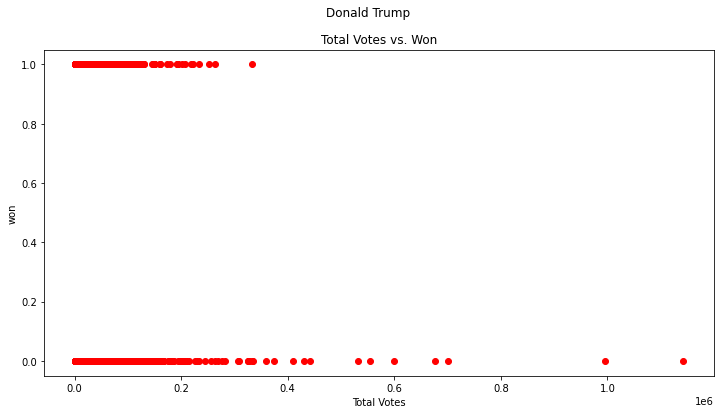

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(trump.total_votes, trump.won, color='r')
plt.xlabel('Total Votes')
plt.ylabel('won')
plt.suptitle('Donald Trump')
plt.title('Total Votes vs. Won')
plt.show()

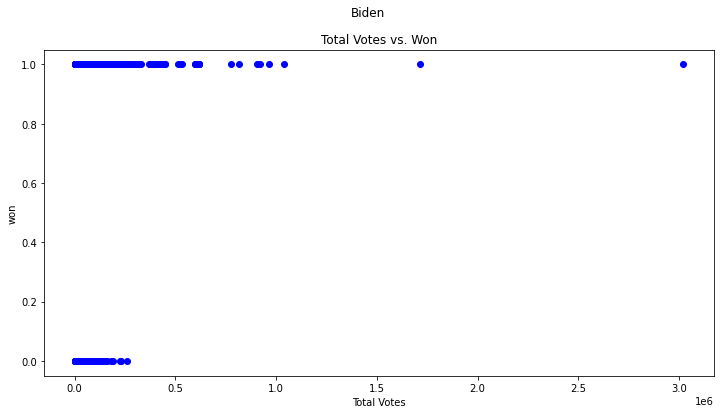

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(biden.total_votes, biden.won, color='b')
plt.xlabel('Total Votes')
plt.ylabel('won')
plt.suptitle('Biden')
plt.title('Total Votes vs. Won')
plt.show()

Show histogram

In [ ]:
x = biden.total_votes
y = trump.total_votes

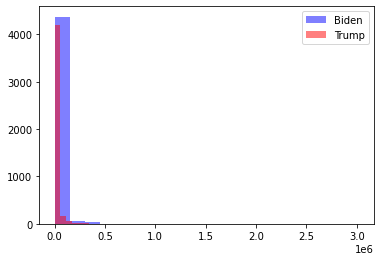

In [ ]:
bins = 20
plt.hist(x, bins, alpha=0.5, color='blue', label='Biden')
plt.hist(y, bins, alpha=0.5, color='red', label='Trump')
plt.legend(loc='upper right')
plt.show()

# 4 - Calculate and Display Mean Votes

Show the mean number of votes across counties for each candidate 

In [ ]:
grp_by = df.groupby('candidate').mean().sort_values('total_votes',ascending=False).rename(columns={'total_votes':'Mean_County_Votes','won':'Win Rate'})
grp_by

,Mean_County_Votes,Win Rate
candidate,,
Joe Biden,17923.47325,0.304057
Donald Trump,16514.39679,0.695943


In [ ]:
grp_by = df.groupby('candidate') 
trump = grp_by.get_group('Donald Trump')
biden = grp_by.get_group('Joe Biden')

In [ ]:
trump.shape

(4486, 6)

In [ ]:
trump

,state,county,candidate,party,total_votes,won
1,Delaware,Kent County,Donald Trump,REP,41009,False
5,Delaware,New Castle County,Donald Trump,REP,88364,False
8,Delaware,Sussex County,Donald Trump,REP,71230,True
13,District of Columbia,District of Columbia,Donald Trump,REP,1703,False
20,District of Columbia,Ward 2,Donald Trump,REP,2874,False
...,...,...,...,...,...,...
31392,Arizona,Graham County,Donald Trump,REP,10749,True
31395,Arizona,Greenlee County,Donald Trump,REP,2433,True
31398,Arizona,La Paz County,Donald Trump,REP,5129,True
31402,Arizona,Maricopa County,Donald Trump,REP,995665,False


In [ ]:
trump_avg_votes, trump_win_pct = trump.mean()
print("Trump Average Votes",'\t',int(trump_avg_votes))
print("Trump Win Percentage",'\t',round(trump_win_pct,3))

Trump Average Votes 	 16514
Trump Win Percentage 	 0.696


In [ ]:
biden

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
4,Delaware,New Castle County,Joe Biden,DEM,195034,True
9,Delaware,Sussex County,Joe Biden,DEM,56682,False
12,District of Columbia,District of Columbia,Joe Biden,DEM,38037,True
19,District of Columbia,Ward 2,Joe Biden,DEM,28185,True
...,...,...,...,...,...,...
31393,Arizona,Graham County,Joe Biden,DEM,4034,False
31396,Arizona,Greenlee County,Joe Biden,DEM,1182,False
31399,Arizona,La Paz County,Joe Biden,DEM,2236,False
31401,Arizona,Maricopa County,Joe Biden,DEM,1040774,True


In [ ]:
biden_avg_votes, biden_win_pct = biden.mean()
print("Biden Average Votes",'\t',int(biden_avg_votes))
print("Biden Win Percentage",'\t',round(biden_win_pct,3))

Biden Average Votes 	 17923
Biden Win Percentage 	 0.304


In [ ]:
biden.shape

(4486, 6)

In [ ]:
df.query('state=="California"')

,state,county,candidate,party,total_votes,won
28817,California,Fresno County,Joe Biden,DEM,192118,True
28818,California,Fresno County,Donald Trump,REP,163880,False
28823,California,Glenn County,Donald Trump,REP,7000,True
28824,California,Glenn County,Joe Biden,DEM,3939,False
28829,California,Humboldt County,Joe Biden,DEM,43633,True
...,...,...,...,...,...,...
29151,California,Contra Costa County,Donald Trump,REP,152497,False
29156,California,Del Norte County,Donald Trump,REP,6444,True
29157,California,Del Norte County,Joe Biden,DEM,4659,False
29162,California,El Dorado County,Donald Trump,REP,61820,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8972 entries, 0 to 31405
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        8972 non-null   object
 1   county       8972 non-null   object
 2   candidate    8972 non-null   object
 3   party        8972 non-null   object
 4   total_votes  8972 non-null   int64 
 5   won          8972 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 429.3+ KB
